We are putting 10 compartments back to back together and connecting all of them and assigning values to fields such as Ra,Rm and Cm. Note that we find these values by multiplying the specific conductances and capacitances by the area of the compartments.

All the compartments are passive compartments without any Hodgkin Huxley type channel associated with them.

The last compartment is treated as the soma.

We will be passing current into a spikgen object using pulsegen and then pass the signal from the spikegen into the compartment. The same process is repeated for all the compartments. 

All measurements will be done at the soma

The compartmens are connected together via messages of 'raxial' and 'axial'

In [1]:
import moose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sim=moose.Neutral('/sim')
model=moose.Neutral(f'{sim.path}/model')
data=moose.Neutral(f'{sim.path}/data')
lib=moose.Neutral('/library')

In [3]:
# compartments will be cylindrical
erest=-70e-3
radius=5e-6
length=20e-6
Cm_spec=1e-2
Gm_spec=3
sarea=2*np.pi*radius*length

In [4]:
def get_proto_comp():
    comp_path=f'{lib.path}/comp'
    if moose.exists(comp_path):
        return moose.element(comp_path)

    # We can vary the parameters and see the effects on the membrane potential of the soma
    proto_comp=moose.Compartment(comp_path)
    proto_comp.Rm=1/(3*sarea)
    proto_comp.Cm=1e-2*sarea
    proto_comp.initVm=erest
    proto_comp.Em= -70e-3
    proto_comp.Ra=proto_comp.Rm # value used: Ra=35.4 ohm/cm
    proto_comp.length=length
    proto_comp.diameter=2*radius

    # spikegen=moose.SpikeGen(f'{proto_comp.path}/spike')
    # moose.connect(proto_comp,'VmOut',spikegen,'Vm')
    
    synchan=moose.SynChan(f'{proto_comp.path}/synchan')
    moose.connect(synchan,'channel',proto_comp,'channel')

    synh=moose.SimpleSynHandler(f'{synchan.path}/synh')
    moose.connect(synh,'activationOut',synchan,'activation')

    synh.numSynapses=1
    synchan.Gbar=1e-6
    synchan.Ek=0.0
    synchan.tau1=1e-3
    synchan.tau2=1e-3

    synh.synapse[0].weight=1
    synh.synapse[0].delay=1e-3

    
    return proto_comp

def get_pulsegen(): # external pulsegen corresponding to each compartment
    pulsegen_path=f'{lib.path}/pulsegen'
    if moose.exists(pulsegen_path):
        return moose.element(pulsegen_path)

    proto_pulsegen=moose.PulseGen(pulsegen_path)
    proto_pulsegen.level[0]=1e-10
    proto_pulsegen.width[0]=20e-3

    return proto_pulsegen
    # we will set the delay timing in the for loop corresponding to each compartment

def get_spikegen(): # External spikegen for each compartment
    spikegen_path=f'{lib.path}/spikegen'
    if moose.exists(spikegen_path):
        return moose.element(spikegen_path)

    proto_spikegen=moose.SpikeGen(spikegen_path)
    proto_spikegen.threshold=5e-11

    return proto_spikegen

In [5]:
proto_comp=get_proto_comp()
proto_pulsegen=get_pulsegen()
proto_spikegen=get_spikegen()

In [6]:
# Note: Membrane potential is being measured in each compartment 

comps=[]
tabs=[]
pulsegen_tabs=[]
pulsegens=[]
spikegens=[]
ncomps=10
for i in range(0,ncomps):

    # assigning objects to their respective paths
    comp_hold=moose.copy(proto_comp,model,f'comp_{i}')
    pulsegen_hold=moose.copy(proto_pulsegen,model,f'pulsegen_{i}')
    spikegen_hold=moose.copy(proto_spikegen,model,f'spikegen_{i}')
    vm_tab=moose.Table(f'{data.path}/vm_{i}')
    pulsegen_tab=moose.Table(f'{data.path}/pulsegentab_{i}')

    # appending lists with their corresponding items
    comps.append(comp_hold)
    pulsegens.append(pulsegen_hold)
    pulsegen_tabs.append(pulsegen_tab)
    spikegens.append(spikegen_hold)
    tabs.append(vm_tab)

    # setting up the connections:
    moose.connect(pulsegens[i],'output',spikegens[i],'Vm') # connecting external pulsegen to external spikegen ('i'th index)
    
    moose.connect(spikegens[i],'spikeOut',moose.element(f'{comps[i].path}/synchan/synh').synapse[0],'addSpike')
    # connecting 'i'th external spikegen to the synhandler of the ith compartment 

    # connecting the tables
    moose.connect(vm_tab,'requestOut',comp_hold,'getVm') # to get membrane potential of each compartment
    moose.connect(pulsegen_tab,'requestOut',pulsegen_hold,'getOutputValue') # to get pulse (current) from each pulsegen
    

    if len(comps)>1:
        moose.connect(moose.element(comps[-2].path),'raxial',moose.element(comps[-1].path),'axial')
        

In [7]:
for i in range(0,10):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[i].path).delay[0]=(10e-3)*n
    moose.element(pulsegens[i].path).delay[1]=1e9

print('')
for i in range(0,10):
    print(f'pusegen_{i} delay: {moose.element(pulsegens[i].path).delay[0]}')


pusegen_0 delay: 0.01
pusegen_1 delay: 0.03
pusegen_2 delay: 0.05
pusegen_3 delay: 0.07
pusegen_4 delay: 0.09
pusegen_5 delay: 0.11
pusegen_6 delay: 0.13
pusegen_7 delay: 0.15
pusegen_8 delay: 0.17
pusegen_9 delay: 0.19


In [8]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

In [9]:
for i in range(ncomps):
    print(f'The spikegen_{i} fired at time: {np.round(moose.element(f'{spikegens[i].path}').lastSpikeTime,4)}')

The spikegen_0 fired at time: 0.01
The spikegen_1 fired at time: 0.03
The spikegen_2 fired at time: 0.05
The spikegen_3 fired at time: 0.07
The spikegen_4 fired at time: 0.09
The spikegen_5 fired at time: 0.11
The spikegen_6 fired at time: 0.13
The spikegen_7 fired at time: 0.15
The spikegen_8 fired at time: 0.17
The spikegen_9 fired at time: 0.19


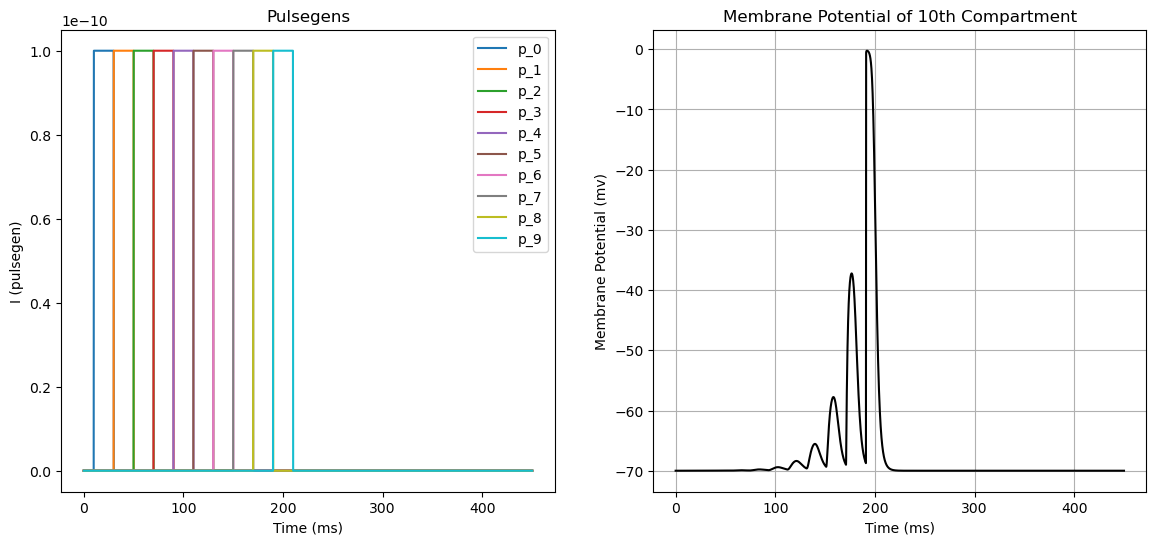

In [10]:
t=np.arange(len(pulsegen_tabs[0].vector))*pulsegen_tabs[0].dt*1e3

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,axes=plt.subplots(1,2,figsize=(14,6))
for i in range(0,10):
    axes[0].plot(t,pulsegen_tabs[i].vector,label=f'p_{i}',color=colors[i])

axes[0].legend()
axes[0].set_ylabel('I (pulsegen)')
axes[0].set_xlabel('Time (ms)')
axes[0].set_title('Pulsegens')

axes[1].plot(t,tabs[9].vector*1e3,color='black')
axes[1].set_title('Membrane Potential of 10th Compartment')
axes[1].set_ylabel('Membrane Potential (mv)')
axes[1].set_xlabel('Time (ms)')
axes[1].grid()

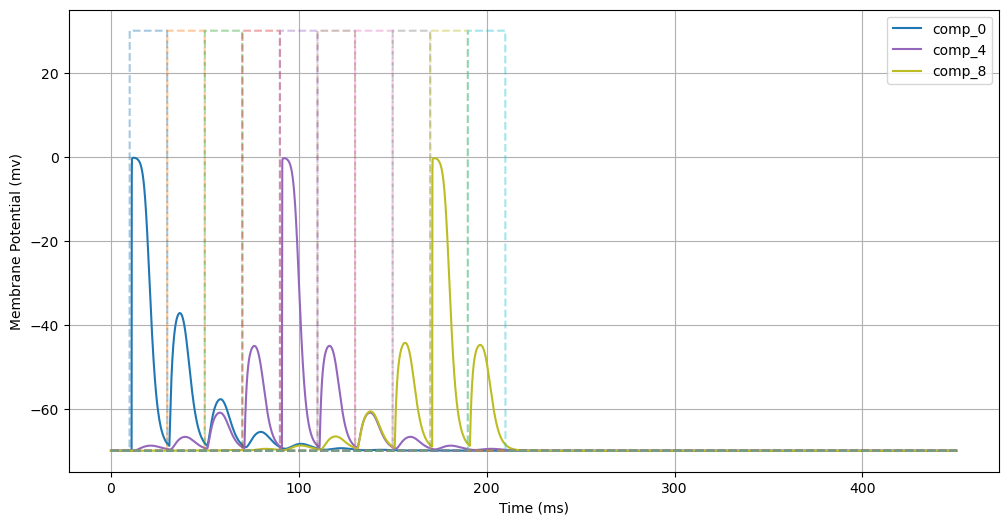

In [11]:
# Membrane Potential evolution due to depolarization in neighbouring compartments
plt.figure(figsize=(12,6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,ncomps,4):
    plt.plot(t,tabs[i].vector*1e3,label=f'comp_{i}',color=colors[i])

for i in range(0,ncomps):
    plt.plot(t,pulsegen_tabs[i].vector*1e12-70,'--',color=colors[i],alpha=0.4)

plt.ylabel('Membrane Potential (mv)')
plt.xlabel('Time (ms)')
plt.grid()
plt.legend()
plt.show()

In [12]:
for i in range(9,-1,-1):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[9-i].path).delay[0]=(10e-3)*n
    moose.element(pulsegens[9-i].path).delay[1]=1e9

for i in range(0,10):
    print(moose.element(pulsegens[i].path).delay[0])

0.19
0.17
0.15
0.13
0.11
0.09
0.07
0.05
0.03
0.01


In [13]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

In [14]:
for i in range(ncomps):
    print(f'The spikegen_{i} fired at time: {np.round(moose.element(f'{spikegens[i].path}').lastSpikeTime,4)}')

The spikegen_0 fired at time: 0.19
The spikegen_1 fired at time: 0.17
The spikegen_2 fired at time: 0.15
The spikegen_3 fired at time: 0.13
The spikegen_4 fired at time: 0.11
The spikegen_5 fired at time: 0.09
The spikegen_6 fired at time: 0.07
The spikegen_7 fired at time: 0.05
The spikegen_8 fired at time: 0.03
The spikegen_9 fired at time: 0.01


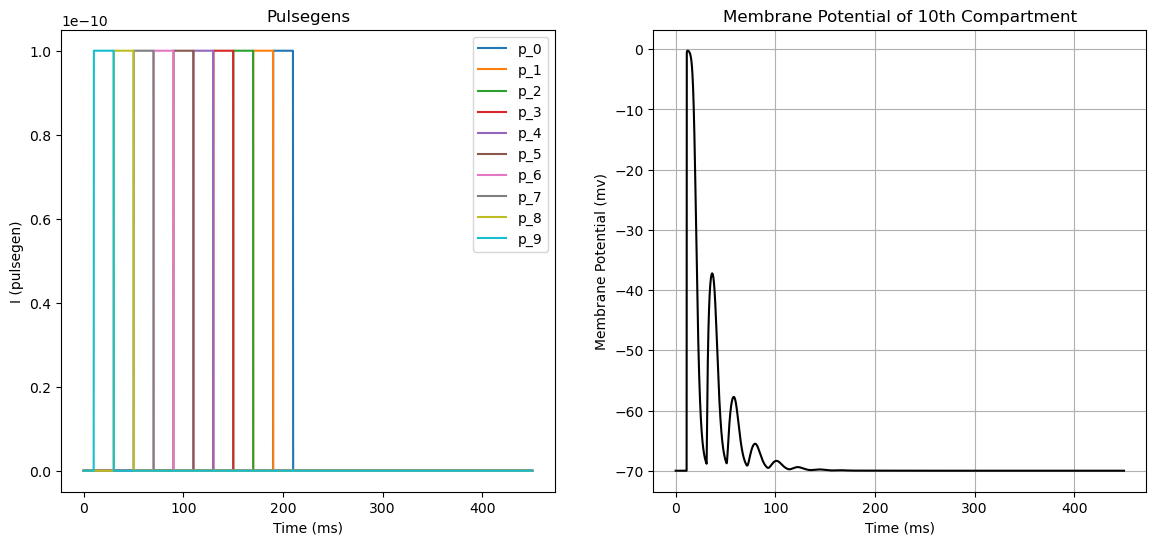

In [15]:
t=np.arange(len(pulsegen_tabs[0].vector))*pulsegen_tabs[0].dt*1e3

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,axes=plt.subplots(1,2,figsize=(14,6))
for i in range(0,10):
    axes[0].plot(t,pulsegen_tabs[i].vector,label=f'p_{i}',color=colors[i])

axes[0].legend()
axes[0].set_ylabel('I (pulsegen)')
axes[0].set_xlabel('Time (ms)')
axes[0].set_title('Pulsegens')

axes[1].plot(t,tabs[9].vector*1e3,color='black')
axes[1].set_title('Membrane Potential of 10th Compartment')
axes[1].set_ylabel('Membrane Potential (mv)')
axes[1].set_xlabel('Time (ms)')
axes[1].grid()

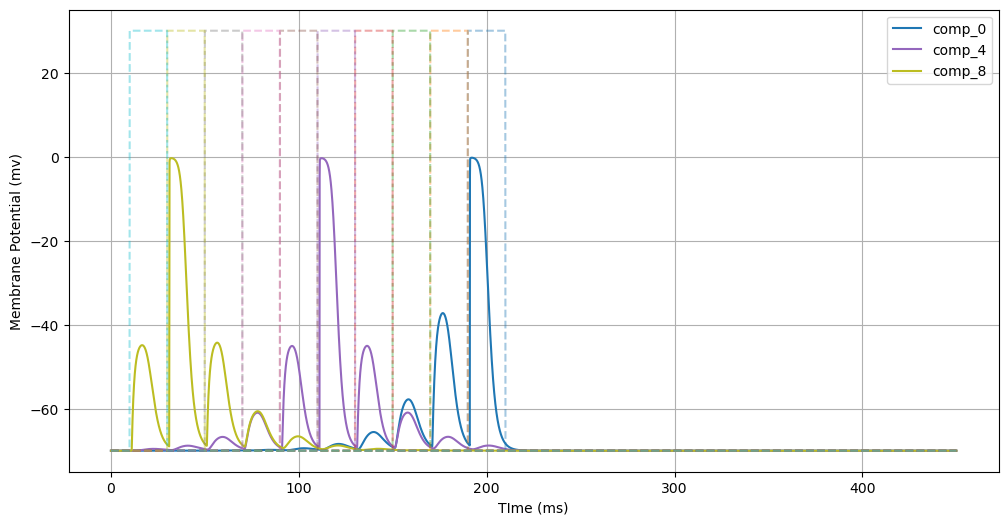

In [16]:
# Membrane Potential evolution due to depolarization in neighbouring compartments
plt.figure(figsize=(12,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,ncomps,4):
    plt.plot(t,tabs[i].vector*1e3,label=f'comp_{i}',color=colors[i])

for i in range(0,ncomps):
    plt.plot(t,pulsegen_tabs[i].vector*1e12-70,'--',color=colors[i],alpha=0.4)

plt.xlabel('TIme (ms)')
plt.ylabel('Membrane Potential (mv)')
plt.grid()
plt.legend()
plt.show()